# Shear strength envelopes

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_slope_stability/blob/main/notebooks/strength_envelopes.ipynb).



## Required modules

In [1]:
import ast # helps with converting str representation of python data structures
import numpy as np
from numpy.polynomial.polynomial import polyfit, Polynomial
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install ipympl', shell=True);
    from google.colab import output
    output.enable_custom_widget_manager()

%matplotlib widget

plt.style.use("default")
colors = ("#DDAA33", "#BB5566", "#004488")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
html_setup = '<style> div.jupyter-widgets.widget-label {display: none;} </style>'

In [2]:
def fit_curved_env(σ, τ, p_atm=100):
    τ_log_nor = np.log(τ/p_atm)
    σ_log_nor = np.log(σ/p_atm)
    log_a, b = polyfit(σ_log_nor, τ_log_nor, deg=1)
    return np.exp(log_a), b


def strength_envelope(σ, τ, curved_env=False, tan_curved_env=False,
                      σ_star=150, widget=False, **kwargs):
    p_atm = kwargs.get('p_atm', 100)
    if type(σ) == str:  # This is for interpreting in from the widget
        σ = ast.literal_eval(f"[{σ}]")
    if type(τ) == str:  # This is for interpreting in from the widget
        τ = ast.literal_eval(f"[{τ}]")
    min_id = min(len(σ), len(τ))
    σ, τ = np.array(σ[:min_id]), np.array(τ[:min_id])
    # Mohr-Coulomb envelope as linear fit of all the points
    c, tan_𝜙 = polyfit(σ, τ, deg=1)
    𝜙 = np.degrees(np.arctan(tan_𝜙))
    linear_env_MC = Polynomial([c, tan_𝜙])
    # Power function envelope (Lade, 2010)
    a, b = fit_curved_env(σ, τ, p_atm)
    curved_env_eq = lambda σ_n: a * p_atm * (σ_n/p_atm) ** b

    # stress vs horizontal deformation plot
    σ_plot = np.linspace(0, 1.2 * max(σ), 100)
    fig = plt.figure(figsize=kwargs.get('figsize', [6, 4]))
    ax = fig.add_subplot(111)
    ax.plot(σ_plot, linear_env_MC(σ_plot), ls="-", color="k",
            label="$\\tau=" + f"{c:.1f}" + "+\\tan(" + f"{𝜙:.1f}"
            + "^\\circ )\\sigma_\\mathrm{n}$")
    if curved_env:
        ax.plot(σ_plot, curved_env_eq(σ_plot), ls="--", color='b',
            label="$\\tau=" + f"{a:.2f}" + "P_\mathrm{a}\left("
            + "\\frac{\sigma}{P_\mathrm{a}}\\right)^{" + f"{b:.2f}" + "}$")
    if tan_curved_env:
        tan_𝜙_tan = a * b * (σ_star/p_atm) ** (b-1)
        𝜙_tan = np.degrees(np.arctan(tan_𝜙_tan))
        c_tan = curved_env_eq(σ_star) - tan_𝜙_tan*σ_star
        linear_env_tan_curved_env = Polynomial([c_tan, tan_𝜙_tan])
        ax.plot(σ_plot, linear_env_tan_curved_env(σ_plot), ls="--", color='r',
            label="$\\tau_{\\sigma_\\mathrm{n}^\star}=" + f"{c_tan:.1f}"
            + "+\\tan(" + f"{𝜙_tan:.1f}" + "^\\circ )\\sigma_\\mathrm{n}$")
        ax.plot(σ_star, curved_env_eq(σ_star), ls="", marker="*", ms=12,
                color='k', label="$\\sigma_\\mathrm{n}^\star$")
    ax.plot(σ, τ, ls='', marker="o", mec='k', mfc='w', ms=7,
            label='Data')
    ax.set_xlabel("normal stress, $\\sigma_\\mathrm{n}$   [$\\mathrm{kPa}$]")
    ax.set_ylabel("shear stress $\\tau$   [$\\mathrm{kPa}$]")
    tau_max = max(τ)
    ax.axis("image")
    ax.set_ylim(
        (0, max(tau_max, linear_env_MC(σ_plot[-1]), curved_env_eq(σ_plot[-1]))))
    ax.set_xlim((0, σ_plot[-1]))
    ax.grid(True, ls="--", lw=0.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.legend()
    if widget:
        display(fig)
    else:
        plt.show()
        display(wgt.HTML(html_setup))
    plt.close()
    return

# strength_envelope(σ=[100, 200, 400], τ=[80, 145, 250], curved_env=True,
#                   tan_curved_env=True, σ_star=0.01)

In [3]:
# Interactive figure
s, l = {'description_width': '200'}, wgt.Layout(width='450px')
s_tan, l_tan = {'description_width': '5'}, wgt.Layout(width='320px')
controls = {
    'σ': wgt.Text(value="48.9, 97.8, 244.5", description="𝜎ₙ", style=s, layout=l),
    'τ': wgt.Text(value="38.2, 57.1, 89.2", description="𝜏ₙ", style=s, layout=l),
    'curved_env': wgt.Checkbox(value=False, description="Plot power function fitting?", style=s, layout=l),
    'tan_curved_env': wgt.Checkbox(value=False, description="Plot tangent to power fit at 𝜎ₙ★?", style=s_tan, layout=l_tan),
    'σ_star': wgt.FloatSlider(value=75, min=0.1, max=250, step=0.2, description="𝜎ₙ★", style=s_tan, layout=wgt.Layout(width='300px')),
    'widget': wgt.Checkbox(value=True, description='Non-vector image (improve widget performance)', style=s, layout=l)
}
c_all = list(controls.values())
c_tan = [wgt.HBox(c_all[3:5])]
c = c_all[:3] + c_tan + c_all[5:]
fig = wgt.interactive_output(strength_envelope, controls)
wgt.HBox((wgt.VBox(c), fig), layout=wgt.Layout(align_items='center'))

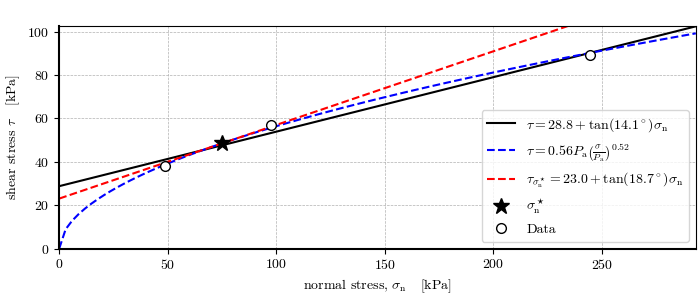

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [4]:
# Non-interactive figure
strength_envelope(
    σ=[48.9, 97.8, 244.5],
    τ=[38.2, 57.1, 89.2],
    curved_env=True,
    tan_curved_env=True,
    σ_star=75,
    figsize=[7, 3]
)